<a href="https://colab.research.google.com/github/rgerraty/hybrid_reinforcement_learning/blob/master/gen_cmnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import grad
from torchvision import transforms
from torchvision import datasets
import torchvision.datasets.utils as dataset_utils
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy.random as random
import urllib

In [0]:
trans=transforms.Compose([
    transforms.RandomCrop(28, padding=2),
    #transforms.RandomHorizontalFlip(),    
    transforms.RandomRotation(2)])
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)



train_mnist = datasets.mnist.MNIST('./data', train=True, download=True)#,transform=trans)
test_mnist = datasets.mnist.MNIST('./data',train=False, download=True)#,transform=trans)


In [5]:
train_mnist

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [0]:
def color_grayscale_arr(arr, dc=[0,0,225],bc=[250,122,0]):
  """Converts grayscale imae to either red or green"""
  assert arr.ndim == 2
  dtype = arr.dtype
  h, w = arr.shape
  dc=np.array(dc,ndmin=3).transpose()
  bc=np.array(bc,ndmin=3).transpose()
  arr = np.reshape(arr, [1,w, h])
  arr=np.repeat(arr,repeats=3,axis=0)
  arr=(arr>0)*dc

  #arr=arr+((arr==0)*bc)
  return arr
  


In [7]:
train_set=[]
id_test_set=[]
od_test_set=[]
#need to add digit and bg colors values for train set
n_train_cols=1
dc_train=random.randint(0,256,(10,3,n_train_cols))
bc_train=random.randint(0,256,(10,3,n_train_cols))
rand_dig=np.array([1,3,5,7,9])#random.randint(0,9,9)

for idx, (im, label) in enumerate(train_mnist):
      if idx % 10000 == 0:
        print(f'Converting image {idx}/{len(train_mnist)}')
      im_array = np.array(im)
      rand_bin=random.randint(0,n_train_cols)
      colored_arr=color_grayscale_arr(im_array,dc=dc_train[label,:,rand_bin],bc=bc_train[label,:,rand_bin])
      colored_arr=colored_arr.astype(np.uint8)

      train_set.append((colored_arr,label))

      dc_train_tmp=random.randint(0,256,(10,3,1))
      bc_train_tmp=random.randint(0,256,(10,3,1))
      #dc_train[rand_dig,:,:]=dc_train_tmp[rand_dig,:,:]
      #bc_train[rand_dig,:,:]=bc_train_tmp[rand_dig,:,:]


for idx, (im, label) in enumerate(test_mnist):
      if idx % 10000 == 0:
        print(f'Converting image {idx}/{len(test_mnist)}')
      im_array = np.array(im)
      rand_bin=random.randint(0,n_train_cols)
      colored_arr=color_grayscale_arr(im_array,dc=dc_train[label,:,rand_bin],bc=bc_train[label,:,rand_bin])
      colored_arr=colored_arr.astype(np.uint8)

      id_test_set.append((colored_arr,label))

      dc_train_tmp=random.randint(0,256,(10,3,1))
      bc_train_tmp=random.randint(0,256,(10,3,1))
      #dc_train[rand_dig,:,:]=dc_train_tmp[rand_dig,:,:]
      #bc_train[rand_dig,:,:]=bc_train_tmp[rand_dig,:,:]

for idx, (im, label) in enumerate(test_mnist):      
      if idx % 10000 == 0:
        print(f'Converting image {idx}/{len(test_mnist)}')
      im_array=np.array(im)
      colored_arr=color_grayscale_arr(im_array,dc=random.randint(0,255,3),bc=random.randint(0,255,3))
      colored_arr=colored_arr.astype(np.uint8)
      #test_set.append((Image.fromarray(colored_arr),label))
      od_test_set.append((colored_arr,label))





Converting image 0/60000
Converting image 10000/60000
Converting image 20000/60000
Converting image 30000/60000
Converting image 40000/60000
Converting image 50000/60000
Converting image 0/10000
Converting image 0/10000


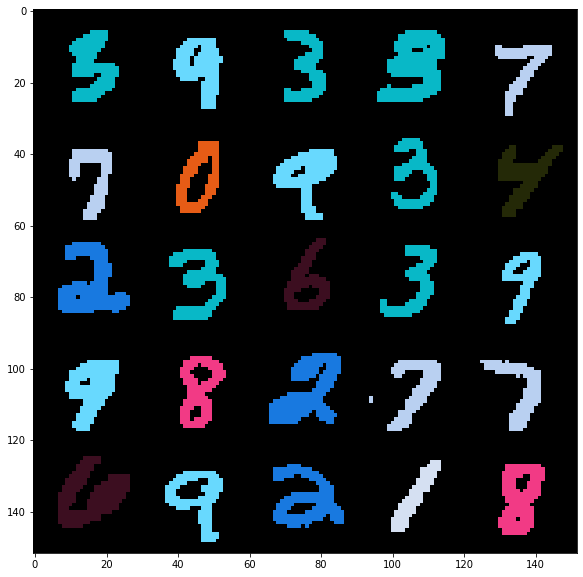

In [8]:

from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
batch_size = 25

train_loader=DataLoader(train_set,batch_size=batch_size,shuffle=True)
batch = next(iter(train_loader))
images = batch[0]
labels = batch[1]
im_size=images.shape[3]
grid = make_grid(images, nrow=np.int(batch_size/5))
#save_image(images, 'stl.png', nrow=12)
plt.figure(figsize=(20,10))
plt.imshow(grid.permute(1,2,0))


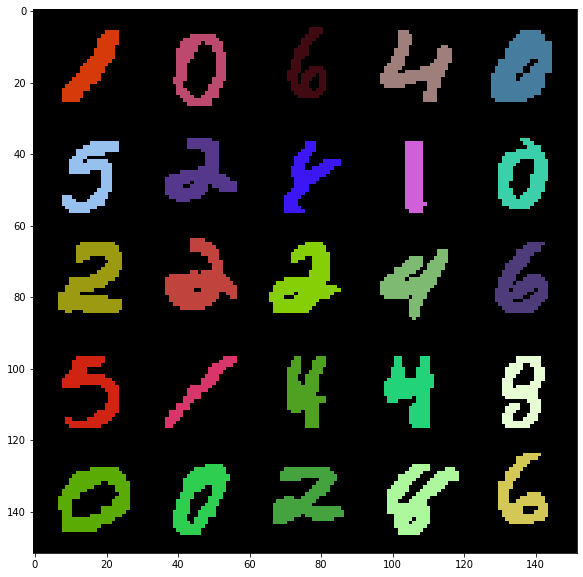

In [9]:

from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
batch_size = 25


train_loader=DataLoader(train_set,batch_size=batch_size,shuffle=True)
od_test_loader=DataLoader(od_test_set,batch_size=batch_size,shuffle=True)
batch = next(iter(od_test_loader))
images = batch[0]
labels = batch[1]
im_size=images.shape[3]
grid = make_grid(images, np.int(batch_size/5))
#save_image(images, 'stl.png', nrow=12)
plt.figure(figsize=(20,10))
plt.imshow(grid.permute(1,2,0))

In [0]:
class b_net(nn.Module):
  def __init__(self,im_size=28,z_dim=50):
    super(b_net,self).__init__()
    self.relu=nn.ReLU()
    self.conv1=nn.Sequential(nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
                                     nn.BatchNorm2d(32))
    self.conv1_relu_mp=nn.Sequential(nn.ReLU(),
                                    nn.MaxPool2d(2))
    
    self.conv2=nn.Sequential(nn.Conv2d(32,32,3,1,1),
                                     nn.BatchNorm2d(32))
    self.conv2_relu_mp=nn.Sequential(nn.ReLU(),
                                     nn.MaxPool2d(2))
    
    self.conv3=nn.Sequential(nn.Conv2d(32,64,3,1,1),
                                     nn.BatchNorm2d(64))
    self.conv3_relu_mp=nn.Sequential(nn.ReLU(),
                                     nn.MaxPool2d(2))
    
    self.fc=nn.Sequential(nn.Linear(3*3*64,z_dim),
                          nn.ReLU())

    self.logits=nn.Linear(z_dim,10)
  
  def forward(self,image,dropp=0):
    conv1=self.conv1(image)
    conv1_relu_mp=self.conv1_relu_mp(conv1)
    conv2=self.conv2(conv1_relu_mp)
    conv2_relu_mp=self.conv2_relu_mp(conv2)
    conv3=self.conv3(conv2_relu_mp)
    conv3_relu_mp=self.conv3_relu_mp(conv3)
    fc=nn.functional.dropout(self.fc(conv3_relu_mp.view(-1,3*3*64)),
                                p=dropp,training=self.training)
    #discrim_fc=self.relu(self.discrim_fc(fc))
    logits=nn.functional.dropout(self.logits(fc),p=dropp,training=self.training)
    logits=self.logits(fc)
    #softmax=self.softmax(fc)

    return logits

    



In [0]:
def create_z_sample(z_mu,z_logsigma,n_samps=1):
    z_sample=0
    z_sigma = torch.exp(z_logsigma)
    eps = torch.randn_like(z_sigma)
    for i in range(n_samps):
      z_sample += eps.mul(z_sigma).add_(z_mu)
    z_sample/=n_samps
    return z_sample


def kl_div_norm(mu1, logsigma1, mu2, logsigma2):
  # KL( N(mu_1, sigma2_1) || N(mu_2, sigma2_2)) = 
  # 
  sigma1 = logsigma1.exp() 
  sigma2=np.exp(logsigma2)
  kld = torch.log(sigma2/sigma1) + (sigma1**2 + (mu1 - mu2)**2)/(2*(sigma2**2)) - 1/2
  return kld.sum()

import math
def get_conv_out_size(W=64,K=4,P=0,S=2):
  o_s=math.floor(((W-K+2*P)/S)+1)
  return o_s

In [0]:
class vb_net(nn.Module):
  def __init__(self,z_dim=20,n_samps=1,im_size=28):
    super(vb_net,self).__init__()
    self.relu=nn.ReLU()

    self.conv1=nn.Sequential(nn.Conv2d(3,32,3,stride=1,padding=1),
                             nn.BatchNorm2d(32)
                             )
    self.conv1_relu_mp=nn.MaxPool2d(2,return_indices=True)
    self.conv1_size=self.conv1_relu_mp(self.conv1(torch.randn(1,3,im_size,im_size)))[0].size()

    

    self.conv2=nn.Sequential(nn.Conv2d(32,32,3,1,1),
                             nn.BatchNorm2d(32)
                             )
    self.conv2_relu_mp=nn.MaxPool2d(2,return_indices=True)
    self.conv2_size=self.conv2_relu_mp(self.conv2(torch.randn(1,self.conv1_size[1],self.conv1_size[2],self.conv1_size[3])))[0].size()

    

    self.conv3=nn.Sequential(nn.Conv2d(32,64,3,1,1),
                             nn.BatchNorm2d(64)
                             )
    self.conv3_relu_mp=nn.MaxPool2d(2,return_indices=True)
    

    self.fc=nn.Sequential(nn.Linear(3*3*64,z_dim),
                          nn.ReLU())
    
    self.z_mu=nn.Linear(z_dim,z_dim)
    self.z_logsigma=nn.Linear(z_dim,z_dim)
    #self.discrim_fc=nn.Linear(z_dim,10)
    self.logits=nn.Linear(z_dim,10)
    #self.softmax=nn.Softmax()

    self.fc2=nn.Sequential(nn.Linear(z_dim,3*3*64),
                           nn.ReLU())
    
    self.bnfc=nn.BatchNorm2d(64)
    
    self.dconv1_unp=nn.Upsample(size=self.conv2_size[2:],mode='nearest')
    self.dconv1=nn.Sequential(nn.Conv2d(64,32,3,1,1),
                              nn.BatchNorm2d(32)
    )

    self.dconv2_unp=nn.Upsample(scale_factor=2,mode='nearest')
    self.dconv2=nn.Sequential(nn.Conv2d(32,32,3,1,1),
                              nn.BatchNorm2d(32)
    )

    self.dconv3_unp=nn.Upsample(scale_factor=2,mode='nearest')
    self.dconv3=nn.Sequential(nn.Conv2d(32,3,3,1,1),
                              #nn.BatchNorm2d(3),
                              nn.Sigmoid())
    
    
  def forward(self,image,validation=False,dropp=0.0):
    conv1=self.conv1(image)
    max1_size = conv1.size()
    conv1_relu_mp,indices1=self.conv1_relu_mp(self.relu(conv1))

    conv2=self.conv2(conv1_relu_mp)
    max2_size = conv2.size()
    conv2_relu_mp,indices2=self.conv2_relu_mp(self.relu(conv2))

    conv3=self.conv3(conv2_relu_mp)
    max3_size = conv3.size()
    conv3_relu_mp,indices3=self.conv3_relu_mp(self.relu(conv3))

    fc=nn.functional.dropout(self.fc(conv3_relu_mp.view(-1,3*3*64)),
                                p=dropp,training=self.training)

    z_mu=self.z_mu(fc)
    z_logsigma=self.z_logsigma(fc)
    if not validation:
      z_samp=create_z_sample(z_mu,z_logsigma)
    else:
      z_samp=z_mu
    #discrim_fc=self.relu(self.discrim_fc(z_samp))
    #logits=nn.functional.dropout(self.logits(z_samp),
     #                            p=dropp,training=self.training)
    logits=self.logits(z_samp)

    kl_div=kl_div_norm(z_mu,z_logsigma,0,0)

    #fc2=self.fc2(z_samp)
    fc2=nn.functional.dropout(self.fc2(z_samp),
                                 p=dropp,training=self.training)
    fc2=self.bnfc(fc2.view(-1,64,3,3))

    dconv1_unp=self.dconv1_unp(fc2)
    dconv1=self.relu(self.dconv1(dconv1_unp))

    dconv2_unp=self.dconv2_unp(dconv1)
    dconv2=self.relu(self.dconv2(dconv2_unp))

    dconv3_unp=self.dconv3_unp(dconv2)
    dconv3=self.dconv3(dconv3_unp)
    
    return dconv3,logits,kl_div

In [0]:
class Recon_loss(nn.Module):
  def __init__(self):
    super(Recon_loss,self).__init__()
    self.loss=nn.BCELoss(reduction='sum')
    #self.loss=lambda rec_x,x:torch.sum(torch.abs(rec_x-x))
  def forward(self,recon_x,image):
    recon_loss=self.loss(recon_x,image)
    return recon_loss

In [0]:
class ivb_net(nn.Module):
  def __init__(self,z_dim=20,n_samps=1,im_size=28):
    super(ivb_net,self).__init__()
    self.relu=nn.ReLU()
    self.recon_loss=Recon_loss()
    self.logit_loss=nn.CrossEntropyLoss(reduction='sum')

    self.conv1=nn.Sequential(nn.Conv2d(3,32,3,stride=1,padding=1),
                             nn.BatchNorm2d(32)
                             )
    self.conv1_relu_mp=nn.MaxPool2d(2,return_indices=True)
    self.conv1_size=self.conv1_relu_mp(self.conv1(torch.randn(1,3,im_size,im_size)))[0].size()

    

    self.conv2=nn.Sequential(nn.Conv2d(32,32,3,1,1),
                             nn.BatchNorm2d(32)
                             )
    self.conv2_relu_mp=nn.MaxPool2d(2,return_indices=True)
    self.conv2_size=self.conv2_relu_mp(self.conv2(torch.randn(1,self.conv1_size[1],self.conv1_size[2],self.conv1_size[3])))[0].size()

    

    self.conv3=nn.Sequential(nn.Conv2d(32,64,3,1,1),
                             nn.BatchNorm2d(64)
                             )
    self.conv3_relu_mp=nn.MaxPool2d(2,return_indices=True)
    

    self.fc=nn.Sequential(nn.Linear(3*3*64,z_dim),
                          nn.ReLU())
    
    self.z_mu=nn.Linear(z_dim,z_dim)
    self.z_logsigma=nn.Linear(z_dim,z_dim)

    self.z_mu_update=nn.Linear(z_dim,z_dim)
    self.z_logsigma_update=nn.Linear(z_dim,z_dim)

    #self.discrim_fc=nn.Linear(z_dim,10)
    self.logits=nn.Linear(z_dim,10)
    #self.softmax=nn.Softmax()

    

    self.fc2=nn.Sequential(nn.Linear(z_dim,3*3*64),
                           nn.ReLU())
    
    self.bnfc=nn.BatchNorm2d(64)
    
    self.dconv1_unp=nn.Upsample(size=self.conv2_size[2:],mode='nearest')
    self.dconv1=nn.Sequential(nn.Conv2d(64,32,3,1,1),
                              nn.BatchNorm2d(32)
    )

    self.dconv2_unp=nn.Upsample(scale_factor=2,mode='nearest')
    self.dconv2=nn.Sequential(nn.Conv2d(32,32,3,1,1),
                              nn.BatchNorm2d(32)
    )

    self.dconv3_unp=nn.Upsample(scale_factor=2,mode='nearest')
    self.dconv3=nn.Sequential(nn.Conv2d(32,3,3,1,1),
                              #nn.BatchNorm2d(3),
                              nn.Sigmoid())
    
    
  def forward(self,image,labels=labels,validation=False,iterations=15,dropp=0):
    kl_div=0
    kl_div_old=0
    recon_loss_old=0
    kl_div_new=0
    recon_loss_new=0
    recon_loss=0
    logit_loss_old=0
    logit_loss_new=0
    logit_loss=0
    error_x=image
    for i in range(iterations):

      conv1=self.conv1(error_x)

      max1_size = conv1.size()
      conv1_relu_mp,indices1=self.conv1_relu_mp(self.relu(conv1))

      conv2=self.conv2(conv1_relu_mp)
      max2_size = conv2.size()
      conv2_relu_mp,indices2=self.conv2_relu_mp(self.relu(conv2))

      conv3=self.conv3(conv2_relu_mp)
      max3_size = conv3.size()
      conv3_relu_mp,indices3=self.conv3_relu_mp(self.relu(conv3))

      fc=nn.functional.dropout(self.fc(conv3_relu_mp.view(-1,3*3*64)),
                                       p=dropp,training=self.training)

      
      if i>0:
        #z_mu+=self.z_mu_error(error_z)
        z_mu=self.z_mu(fc)+self.z_mu_update(z_mu)
        #z_logsigma+=self.z_logsigma_error(error_z)
        z_logsigma=self.z_logsigma(fc)+self.z_logsigma_update(z_logsigma)

      else:
        z_mu=self.z_mu(fc)
        #z_mu+=self.z_mu_update(torch.zeros_like(z_mu))
        z_logsigma=self.z_logsigma(fc)
        #z_logsigma+=self.z_logsigma_update(torch.zeros_like(z_logsigma))
    
      if not validation:
        z_samp=create_z_sample(z_mu,z_logsigma)
      else:
        z_samp=z_mu
      #discrim_fc=self.relu(self.discrim_fc(z_samp))
      

      

      #fc2=self.fc2(z_samp)
      fc2=nn.functional.dropout(self.fc2(z_samp),
                                       p=dropp,training=self.training)
      fc2=self.bnfc(fc2.view(-1,64,3,3))

      dconv1_unp=self.dconv1_unp(fc2)
      dconv1=self.relu(self.dconv1(dconv1_unp))

      dconv2_unp=self.dconv2_unp(dconv1)
      dconv2=self.relu(self.dconv2(dconv2_unp))

      dconv3_unp=self.dconv3_unp(dconv2)
      dconv3=self.dconv3(dconv3_unp)

      error_x=image-dconv3
      #error_z=z_samp
      
      kl_div_new=kl_div_norm(z_mu,z_logsigma,0,0)
      #kl_div+=(kl_div_new-kl_div_old)
      #
      kl_div+=(kl_div_new-kl_div_old)*np.exp(-.2*i)
      kl_div_old=kl_div_new

      recon_loss_new=self.recon_loss(dconv3,image)
      #recon_loss+=(recon_loss_new-recon_loss_old)
      
      recon_loss+=(recon_loss_new-recon_loss_old)*np.exp(-.2*i)
      recon_loss_old=recon_loss_new

      logits=self.logits(z_samp)
      logit_loss_new=self.logit_loss(logits,labels)
      #logit_loss+=(logit_loss_new-logit_loss_old)
      #
      logit_loss+=(logit_loss_new-logit_loss_old)*np.exp(-.2*i)
      logit_loss_old=logit_loss_new

      recon_loss+=logit_loss
    
    #logits=nn.functional.dropout(self.logits(z_samp),p=dropp,training=self.training)
    
    return dconv3,logits,kl_div,recon_loss

In [0]:
class ivb2_net(nn.Module):
  def __init__(self,z_dim=20,n_samps=1,im_size=28):
    super(ivb2_net,self).__init__()
    self.relu=nn.ReLU()
    self.recon_loss=Recon_loss()
    self.logit_loss=nn.CrossEntropyLoss(reduction='sum')

    self.conv1=nn.Sequential(nn.Conv2d(3,32,3,stride=1,padding=1),
                             nn.BatchNorm2d(32)
                             )
    self.conv1_relu_mp=nn.MaxPool2d(2,return_indices=True)
    self.conv1_size=self.conv1_relu_mp(self.conv1(torch.randn(1,3,im_size,im_size)))[0].size()

    

    self.conv2=nn.Sequential(nn.Conv2d(32,32,3,1,1),
                             nn.BatchNorm2d(32)
                             )
    self.conv2_relu_mp=nn.MaxPool2d(2,return_indices=True)
    self.conv2_size=self.conv2_relu_mp(self.conv2(torch.randn(1,self.conv1_size[1],self.conv1_size[2],self.conv1_size[3])))[0].size()

    

    self.conv3=nn.Sequential(nn.Conv2d(32,64,3,1,1),
                             nn.BatchNorm2d(64)
                             )
    self.conv3_relu_mp=nn.MaxPool2d(2,return_indices=True)
    

    self.fc=nn.Sequential(nn.Linear(3*3*64,z_dim),
                          nn.ReLU())
    
    self.z_mu=nn.Linear(z_dim,z_dim)
    self.z_logsigma=nn.Linear(z_dim,z_dim)


    self.conv1_update=nn.Sequential(nn.Conv2d(3,32,3,stride=1,padding=1),
                             nn.BatchNorm2d(32)
                             )
    self.conv1_relu_mp_update=nn.MaxPool2d(2,return_indices=True)
    self.conv1_size_update=self.conv1_relu_mp(self.conv1(torch.randn(1,3,im_size,im_size)))[0].size()

    

    self.conv2_update=nn.Sequential(nn.Conv2d(32,32,3,1,1),
                             nn.BatchNorm2d(32)
                             )
    self.conv2_relu_mp_update=nn.MaxPool2d(2,return_indices=True)
    self.conv2_size_update=self.conv2_relu_mp(self.conv2(torch.randn(1,self.conv1_size[1],self.conv1_size[2],self.conv1_size[3])))[0].size()

    

    self.conv3_update=nn.Sequential(nn.Conv2d(32,64,3,1,1),
                             nn.BatchNorm2d(64)
                             )
    self.conv3_relu_mp_update=nn.MaxPool2d(2,return_indices=True)
    

    self.fc_update=nn.Sequential(nn.Linear(3*3*64,z_dim),
                          nn.ReLU())
    
    self.z_mu_update=nn.Linear(z_dim,z_dim)
    self.z_logsigma_update=nn.Linear(z_dim,z_dim)

    #self.discrim_fc=nn.Linear(z_dim,10)
    self.logits=nn.Linear(z_dim,10)
    #self.softmax=nn.Softmax()

    

    self.fc2=nn.Sequential(nn.Linear(z_dim,3*3*64),
                           nn.ReLU())
    
    self.bnfc=nn.BatchNorm2d(64)
    
    self.dconv1_unp=nn.Upsample(size=self.conv2_size[2:],mode='nearest')
    self.dconv1=nn.Sequential(nn.Conv2d(64,32,3,1,1),
                              nn.BatchNorm2d(32)
    )

    self.dconv2_unp=nn.Upsample(scale_factor=2,mode='nearest')
    self.dconv2=nn.Sequential(nn.Conv2d(32,32,3,1,1),
                              nn.BatchNorm2d(32)
    )

    self.dconv3_unp=nn.Upsample(scale_factor=2,mode='nearest')
    self.dconv3=nn.Sequential(nn.Conv2d(32,3,3,1,1),
                              #nn.BatchNorm2d(3),
                              nn.Sigmoid())
    
    
  def forward(self,image,labels=labels,validation=False,iterations=15,dropp=0):
    kl_div=0
    kl_div_old=0
    recon_loss_old=0
    kl_div_new=0
    recon_loss_new=0
    recon_loss=0
    logit_loss_old=0
    logit_loss_new=0
    logit_loss=0

    for i in range(iterations):

      

      
      if i==0:
        conv1=self.conv1(image)

        max1_size = conv1.size()
        conv1_relu_mp,indices1=self.conv1_relu_mp(self.relu(conv1))

        conv2=self.conv2(conv1_relu_mp)
        max2_size = conv2.size()
        conv2_relu_mp,indices2=self.conv2_relu_mp(self.relu(conv2))

        conv3=self.conv3(conv2_relu_mp)
        max3_size = conv3.size()
        conv3_relu_mp,indices3=self.conv3_relu_mp(self.relu(conv3))

        fc=nn.functional.dropout(self.fc(conv3_relu_mp.view(-1,3*3*64)),
                                       p=dropp,training=self.training)
        #z_mu+=self.z_mu_error(error_z)
        z_mu=self.z_mu(fc)
        #z_logsigma+=self.z_logsigma_error(error_z)
        z_logsigma=self.z_logsigma(fc)

      else:
        conv1=self.conv1_update(error_x)

        max1_size = conv1.size()
        conv1_relu_mp,indices1=self.conv1_relu_mp(self.relu(conv1))

        conv2=self.conv2_update(conv1_relu_mp)
        max2_size = conv2.size()
        conv2_relu_mp,indices2=self.conv2_relu_mp_update(self.relu(conv2))

        conv3=self.conv3_update(conv2_relu_mp)
        max3_size = conv3.size()
        conv3_relu_mp,indices3=self.conv3_relu_mp_update(self.relu(conv3))

        fc=nn.functional.dropout(self.fc_update(conv3_relu_mp.view(-1,3*3*64)),
                                       p=dropp,training=self.training)
        z_mu=z_mu+self.z_mu_update(fc)
        #z_mu+=self.z_mu_update(torch.zeros_like(z_mu))
        z_logsigma=z_logsigma+self.z_logsigma_update(fc)
        #z_logsigma+=self.z_logsigma_update(torch.zeros_like(z_logsigma))
    
      if not validation:
        z_samp=create_z_sample(z_mu,z_logsigma)
      else:
        z_samp=z_mu
      #discrim_fc=self.relu(self.discrim_fc(z_samp))
      

      

      #fc2=self.fc2(z_samp)
      fc2=nn.functional.dropout(self.fc2(z_samp),
                                       p=dropp,training=self.training)
      fc2=self.bnfc(fc2.view(-1,64,3,3))

      dconv1_unp=self.dconv1_unp(fc2)
      dconv1=self.relu(self.dconv1(dconv1_unp))

      dconv2_unp=self.dconv2_unp(dconv1)
      dconv2=self.relu(self.dconv2(dconv2_unp))

      dconv3_unp=self.dconv3_unp(dconv2)
      dconv3=self.dconv3(dconv3_unp)

      error_x=image-dconv3
      #error_z=z_samp
      
      kl_div_new=kl_div_norm(z_mu,z_logsigma,0,0)
      #kl_div+=(kl_div_new-kl_div_old)
      #
      kl_div+=(kl_div_new-kl_div_old)*np.exp(-.1*i)
      kl_div_old=kl_div_new

      recon_loss_new=self.recon_loss(dconv3,image)
      #recon_loss+=(recon_loss_new-recon_loss_old)
      
      recon_loss+=(recon_loss_new-recon_loss_old)*np.exp(-.1*i)
      recon_loss_old=recon_loss_new

      logits=self.logits(z_samp)
      logit_loss_new=self.logit_loss(logits,labels)
      #logit_loss+=(logit_loss_new-logit_loss_old)
      #
      logit_loss+=(logit_loss_new-logit_loss_old)*np.exp(-.1*i)
      logit_loss_old=logit_loss_new

      recon_loss+=logit_loss
    
    #logits=nn.functional.dropout(self.logits(z_samp),p=dropp,training=self.training)
    
    return dconv3,logits,kl_div,recon_loss

In [0]:
class rvbt_net(nn.Module):
  def __init__(self,z_dim=20,n_samps=1,im_size=28):
    super(rvbt_net,self).__init__()
    self.relu=nn.ReLU()
    self.recon_loss=Recon_loss()

    self.conv1=nn.Sequential(nn.Conv2d(3,32,3,stride=1,padding=1),
                             nn.BatchNorm2d(32)
                             )
    self.conv1_relu_mp=nn.MaxPool2d(2,return_indices=True)
    self.conv1_size=self.conv1_relu_mp(self.conv1(torch.randn(1,3,im_size,im_size)))[0].size()

    

    self.conv2=nn.Sequential(nn.Conv2d(32,32,3,1,1),
                             nn.BatchNorm2d(32)
                             )
    self.conv2_relu_mp=nn.MaxPool2d(2,return_indices=True)
    self.conv2_size=self.conv2_relu_mp(self.conv2(torch.randn(1,self.conv1_size[1],self.conv1_size[2],self.conv1_size[3])))[0].size()

    

    self.conv3=nn.Sequential(nn.Conv2d(32,64,3,1,1),
                             nn.BatchNorm2d(64)
                             )
    self.conv3_relu_mp=nn.MaxPool2d(2,return_indices=True)
    

    self.fc=nn.Sequential(nn.Linear(3*3*64,z_dim),
                          nn.ReLU())
    
    self.z_mu=nn.Linear(z_dim,z_dim)
    self.z_logsigma=nn.Linear(z_dim,z_dim)

    #self.z_mu_error=nn.Linear(z_dim,z_dim)
    self.z_mu_current=nn.Linear(z_dim,z_dim)
    #self.z_logsigma_error=nn.Linear(z_dim,z_dim)
    self.z_logsigma_current=nn.Linear(z_dim,z_dim)

    #self.discrim_fc=nn.Linear(z_dim,10)
    self.logits=nn.Linear(z_dim,10)
    #self.softmax=nn.Softmax()

    

    self.fc2=nn.Sequential(nn.Linear(z_dim,3*3*64),
                           nn.ReLU())
    
    self.bnfc=nn.BatchNorm2d(64)
    
    self.dconv1_unp=nn.Upsample(size=self.conv2_size[2:],mode='nearest')
    self.dconv1=nn.Sequential(nn.Conv2d(64,32,3,1,1),
                              nn.BatchNorm2d(32)
    )

    self.dconv2_unp=nn.Upsample(scale_factor=2,mode='nearest')
    self.dconv2=nn.Sequential(nn.Conv2d(32,32,3,1,1),
                              nn.BatchNorm2d(32)
    )

    self.dconv3_unp=nn.Upsample(scale_factor=2,mode='nearest')
    self.dconv3=nn.Sequential(nn.Conv2d(32,3,3,1,1),
                              nn.BatchNorm2d(3),
                              nn.Sigmoid())
    
    
  def forward(self,image,validation=True,iterations=10):
    kl_div=0
    recon_loss=0
    error_x=image
    for i in range(iterations):

      conv1=self.conv1(error_x)

      max1_size = conv1.size()
      conv1_relu_mp,indices1=self.conv1_relu_mp(self.relu(conv1))

      conv2=self.conv2(conv1_relu_mp)
      max2_size = conv2.size()
      conv2_relu_mp,indices2=self.conv2_relu_mp(self.relu(conv2))

      conv3=self.conv3(conv2_relu_mp)
      max3_size = conv3.size()
      conv3_relu_mp,indices3=self.conv3_relu_mp(self.relu(conv3))

      fc=self.fc(conv3_relu_mp.view(-1,3*3*64))

      
      if i>0:
        #z_mu+=self.z_mu_error(error_z)
        z_mu=self.z_mu(fc)+self.z_mu_current(z_mu)
        #z_logsigma+=self.z_logsigma_error(error_z)
        z_logsigma=self.z_logsigma(fc)+self.z_logsigma_current(z_logsigma)

      else:
        z_mu=self.z_mu(fc)
        z_mu+=self.z_mu_current(torch.zeros_like(z_mu))
        z_logsigma=self.z_logsigma(fc)
        z_logsigma+=self.z_logsigma_current(torch.zeros_like(z_logsigma))
    
      if not validation:
        z_samp=create_z_sample(z_mu,z_logsigma)
      else:
        z_samp=z_mu
      #discrim_fc=self.relu(self.discrim_fc(z_samp))
      

      

      fc2=self.fc2(z_samp)
      fc2=self.bnfc(fc2.view(-1,64,3,3))

      dconv1_unp=self.dconv1_unp(fc2)
      dconv1=self.relu(self.dconv1(dconv1_unp))

      dconv2_unp=self.dconv2_unp(dconv1)
      dconv2=self.relu(self.dconv2(dconv2_unp))

      dconv3_unp=self.dconv3_unp(dconv2)
      dconv3=self.dconv3(dconv3_unp)

      error_x=image-dconv3
      #error_z=z_samp
      kl_div+=(kl_div_norm(z_mu,z_logsigma,0,0)-kl_div)
      recon_loss+=(self.recon_loss(dconv3,image)-recon_loss)
    
    logits=self.logits(z_samp)
    
    return dconv3,logits,kl_div,recon_loss

In [0]:
class label_loss(nn.Module):
  def __init__(self):
    super(label_loss,self).__init__()
    self.loss=nn.CrossEntropyLoss(reduction='sum')
  def forward(self,softmax,label,recon_loss=0,kl_loss=0,tau=1,beta=1):
    loss=self.loss(softmax,label)
    return (tau*loss)+recon_loss+beta*kl_loss


In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size=25
model=ivb2_net(z_dim=50).to(device)
loss_=label_loss()
recon_loss_=Recon_loss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)

if 0: 
  for name,param in model.named_parameters():
    if name=='conv1.weight' or name=='conv1.bias':
      param.requires_grad=False
  optimizer=torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=1e-3)


train_loader=DataLoader(train_set,batch_size=batch_size,shuffle=True)
id_test_loader=DataLoader(id_test_set,batch_size=batch_size,shuffle=True)
od_test_loader=DataLoader(od_test_set,batch_size=batch_size,shuffle=True)

In [0]:
seed = 0

train_loss = []
train_acc=[]
id_test_loss = []
id_test_acc = []
od_test_loss = []
od_test_acc = []
#test_label=[]
beta=1

In [0]:
def train(batch,epoch,train_size):
  x=batch[0].float().to(device)/255
  model.train()
  kl_loss=0
  recon_loss=0
  acc=0
  loss=0
  model.zero_grad()
  optimizer.zero_grad()
  label_ind=batch[1].to(device)
  label=torch.eye(10)[label_ind].to(device) 

  if model._get_name()=='b_net':
    logits=model(x)
    recon=0
  elif model._get_name()=='vb_net' or model._get_name()=='hvb_net':
    recon,logits,kl_loss=model(x,validation=False)
    recon_loss=recon_loss_(recon,x)
  elif model._get_name()=='ivb_net' or model._get_name()=='ivb2_net':
    recon,logits,kl_loss,recon_loss=model(x,label_ind,validation=False)
   

  pred_lab=np.argmax(np.exp(logits.to('cpu').detach()),1)
  
  
  loss=loss_(logits,label_ind,recon_loss=recon_loss,kl_loss=kl_loss,tau=tau,beta=beta)
    
   
  acc=torch.sum((label_ind==pred_lab.to(device))+0).to('cpu').numpy()
  acc=acc/train_size
  
  loss.backward()
  optimizer.step()
  loss=loss/train_size
  
  return x,label,pred_lab,recon,logits,acc,loss

In [0]:
def test(batch,epoch,test_size):
  x=batch[0].float().to(device)/255
  loss=0
  kl_loss=0
  recon_loss=0
  acc=0
  with torch.no_grad():
    label_ind=batch[1].to(device)
    label=torch.eye(10)[label_ind].to(device)  
    if model._get_name()=='b_net':
      logits=model(x)
      recon=0
    elif model._get_name()=='vb_net' or model._get_name()=='hvb_net':
      recon,logits,kl_loss=model(x,validation=True)
      recon_loss=recon_loss_(recon,x)
    elif model._get_name()=='ivb_net' or model._get_name()=='ivb2_net':
      recon,logits,kl_loss,recon_loss=model(x,label_ind,validation=True)
      

    pred_lab=np.argmax(np.exp(logits.to('cpu').detach()),1)
  
    loss=loss_(logits,label_ind,recon_loss=recon_loss,kl_loss=kl_loss,tau=tau,beta=beta)
    loss=loss/test_size
    acc=torch.sum((label_ind==pred_lab.to(device))+0).to('cpu').numpy()
    acc=acc/test_size

    
  
  return(x,label,pred_lab,recon,logits,acc,loss)


In [0]:
tau=1
beta=1
n_iter=np.int(np.floor(len(train_loader.dataset)/train_loader.batch_size))
num_steps=200
num_epochs=30
for i in range(num_epochs-1):
  train_loader=DataLoader(train_set,batch_size=batch_size,shuffle=True)
  id_test_loader=DataLoader(id_test_set,batch_size=batch_size,shuffle=True)
  od_test_loader=DataLoader(od_test_set,batch_size=batch_size,shuffle=True)
  it_train=iter(train_loader)
  it_test_id=iter(id_test_loader)
  it_test_od=iter(od_test_loader)
  tr_acc=0
  tr_loss=0
  for j in range(n_iter):

    data=next(it_train)
    x,label,pred_lab,recon,logits,acc,loss=train(data,i,batch_size)
    tr_acc+=acc/num_steps
    tr_loss+=loss/num_steps

    if (j % num_steps)==0 and (j>0):
      train_acc.append(np.float16(tr_acc))
      train_loss.append(np.float16(tr_loss.cpu().detach().numpy()))
      print('====> Epoch: {} Average loss: {:.4f} Accuracy: {:.2f} '.format(i, loss,acc))

      data=next(it_test_id)
      x,label,pred_lab,recon,logits,acc,loss=test(data,i,batch_size)
      print('====> Epoch: {} ID Test set loss: {:.4f} Accuracy: {:.2f} '.format(i, loss,acc))
      id_test_loss.append(np.float16(loss.cpu().detach().numpy()))
      id_test_acc.append(np.float16(acc))

      data=next(it_test_od)
      x,label,pred_lab,recon,logits,acc,loss=test(data,i,batch_size)
      print('====> Epoch: {} OD Test set loss: {:.4f} Accuracy: {:.2f} '.format(i, loss,acc))
      od_test_loss.append(np.float16(loss.cpu().detach().numpy()))
      od_test_acc.append(np.float16(acc))
      tr_acc=0
      tr_loss=0
      #test_label.append(label)
    
  beta=1/(i+1)

In [0]:
torch.save(model.state_dict(), model._get_name())

In [0]:
from google.colab import files

files.download(model._get_name())

In [0]:
from google.colab import files
files.upload()

In [27]:
model.load_state_dict(torch.load(model._get_name()))


<All keys matched successfully>

In [28]:
it=iter(train_loader)
itt=iter(id_test_loader)
ittt=iter(od_test_loader)
data=next(ittt)
x=data[0].float().to(device)/255
label_ind=data[1].to(device)
label=torch.eye(10)[label_ind].to(device)
if model._get_name()=='vb_net' or model._get_name()=='hvb_net':
  recon,logits,kl_loss=model(x,validation=True)
elif model._get_name()=='b_net':
  logits=model(x)

else: 
  recon,logits,kl_loss,recon_loss=model(x,label_ind,validation=True)
dig=random.randint(0,batch_size)
Image.fromarray((data[0][dig].numpy().astype(np.uint8).transpose(1,2,0)))

In [29]:
Image.fromarray((recon.detach().to('cpu').numpy()[dig,:,:,:]*255).astype(np.uint8).transpose(1,2,0))

<BarContainer object of 10 artists>

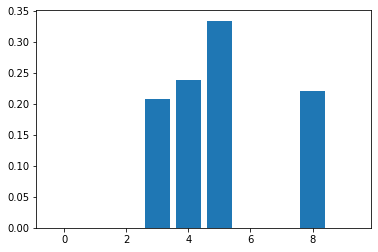

In [30]:
plt.bar(np.array(range(10)),(logits[dig].exp()/(logits[dig].exp().sum())).detach().cpu())

In [0]:
train_acc[:]=[1.0 if i>1.0 else i for i in train_acc]
fig, ax = plt.subplots(constrained_layout=True)
plt.plot(train_acc,label="Training")
#plt.plot(np.arange(num_epochs)*num_steps,test_acc,label="Validation")
#plt.title("Accuracy: Training")
plt.xlabel("Number of steps")
plt.ylabel("Accuracy")
plt.legend()

plt.show()
  

In [0]:
id_test_acc[:]=[1.0 if i>1.0 else i for i in id_test_acc]

fig, ax = plt.subplots(constrained_layout=True)
plt.plot(id_test_acc,label="ID Test")
plt.plot(od_test_acc,label="OD Test")
#plt.title("Accuracy: Testing")
plt.xlabel("Number of steps")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [0]:
fig, ax = plt.subplots(constrained_layout=True)
plt.plot(id_test_loss,label="ID Test")
plt.plot(od_test_loss,label="OD Test")
#plt.title("Loss: Testing")
plt.xlabel("Number of steps")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [0]:
import csv

with open(model._get_name()+'.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(zip(train_acc, id_test_acc,od_test_acc,id_test_loss,od_test_loss))

In [0]:
from google.colab import files

files.download(model._get_name()+'.csv')

In [0]:
od_train_loss=[]
od_train_acc=[]

In [0]:
#beta=1
tau=1
itt=iter(od_test_loader)
for name,param in model.named_parameters():
    if name=='logits.weight' or name=='logits.bias' or name=='discrim_fc.weight' or name=='discrim_fc.bias':
      param.requires_grad=True
      print(name)
    else:
      param.requires_grad=False
optimizer=torch.optim.SGD(model.parameters(),lr=0.0001)
#optimizer=torch.optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()),lr=1e-3)
for epoch in range(399):
  data=next(itt)
  x,label,pred_lab,recon,logits,acc,loss=train(data,epoch,batch_size)
  print('====> Epoch: {} OD Test set loss: {:.4f} Accuracy: {:.2f} '.format(epoch, loss,acc))
  od_train_loss.append(loss)
  od_train_acc.append(acc)

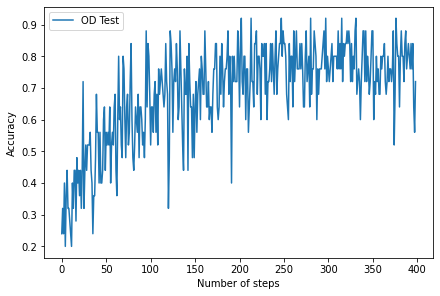

In [36]:
fig, ax = plt.subplots(constrained_layout=True)
plt.plot(od_train_acc,label="OD Test")
#plt.title("Accuracy: OD Training")
plt.xlabel("Number of steps")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [0]:
#need to fix
class hvb_net(nn.Module):
  def __init__(self,z_dim=32,n_samps=1,im_size=28):
    super(hvb_net,self).__init__()
    self.relu=nn.ReLU()

    self.conv1=nn.Sequential(nn.Conv2d(3,32,3,stride=1,padding=1),
                                     nn.BatchNorm2d(32))
    self.conv1_relu_mp=nn.MaxPool2d(2,return_indices=True)
    self.conv1_size=self.conv1_relu_mp(self.conv1(torch.randn(1,3,im_size,im_size)))[0].size()
    self.z1_mu=nn.Linear(self.conv1_size[1]*(self.conv1_size[2]**2),self.conv1_size[1]*(self.conv1_size[2]**2))
    self.z1_logsigma=nn.Linear(self.conv1_size[1]*(self.conv1_size[2]**2),self.conv1_size[1]*(self.conv1_size[2]**2))
    self.z1_pred=nn.Linear(self.conv1_size[1]*(self.conv1_size[2]**2),10)

    self.conv2=nn.Sequential(nn.Conv2d(32,32,3,1,1),
                                     nn.BatchNorm2d(32))
    self.conv2_relu_mp=nn.MaxPool2d(2,return_indices=True)
    self.conv2_size=self.conv2_relu_mp(self.conv2(torch.randn(1,self.conv1_size[1],self.conv1_size[2],self.conv1_size[3])))[0].size()
    self.z2_mu=nn.Linear(self.conv2_size[1]*(self.conv2_size[2]**2),self.conv2_size[1]*(self.conv2_size[2]**2))
    self.z2_logsigma=nn.Linear(self.conv2_size[1]*(self.conv2_size[2]**2),self.conv2_size[1]*(self.conv2_size[2]**2))
    self.z2_pred=nn.Linear(self.conv2_size[1]*(self.conv2_size[2]**2),20)

    self.conv3=nn.Sequential(nn.Conv2d(32,64,3,1,1),
                                     nn.BatchNorm2d(64))
    self.conv3_relu_mp=nn.MaxPool2d(2,return_indices=True)
    self.conv3_size=self.conv3_relu_mp(self.conv3(torch.randn(1,self.conv2_size[1],self.conv2_size[2],self.conv2_size[3])))[0].size()
    self.z3_mu=nn.Linear(self.conv3_size[1]*(self.conv3_size[2]**2),self.conv3_size[1]*(self.conv3_size[2]**2))
    self.z3_logsigma=nn.Linear(self.conv3_size[1]*(self.conv3_size[2]**2),self.conv3_size[1]*(self.conv3_size[2]**2))
    self.z3_pred=nn.Linear(self.conv3_size[1]*(self.conv3_size[2]**2),30)
    #print(self.conv1_size,self.conv2_size,self.conv3_size)

    self.fc=nn.Sequential(nn.Linear(3*3*64,z_dim),
                          nn.ReLU())
    
    self.z4_mu=nn.Linear(z_dim,z_dim)
    self.z4_logsigma=nn.Linear(z_dim,z_dim)
    self.logits=nn.Linear(z_dim,10)
    #self.softmax=nn.Softmax()

    self.fc2=nn.Linear(z_dim,3*3*64)
    self.bnfc=nn.BatchNorm2d(64)
    
    self.z2d1=nn.Linear(self.conv3_size[1]*(self.conv3_size[2]**2),self.conv3_size[1]*(self.conv3_size[2]**2))
    self.dconv1_unp=nn.Upsample(size=self.conv2_size[2:],mode='nearest')
    self.dconv1=nn.Sequential(nn.Conv2d(64,32,3,1,1),
                              nn.BatchNorm2d(32)
    )

    self.z2d2=nn.Linear(self.conv2_size[1]*(self.conv2_size[2]**2),self.conv2_size[1]*(self.conv2_size[2]**2))
    self.dconv2_unp=nn.Upsample(scale_factor=2,mode='nearest')
    self.dconv2=nn.Sequential(nn.Conv2d(32,32,3,1,1),
                              nn.BatchNorm2d(32)
    )

    self.z2d3=nn.Linear(self.conv1_size[1]*(self.conv1_size[2]**2),self.conv1_size[1]*(self.conv1_size[2]**2))
    self.dconv3_unp=nn.Upsample(scale_factor=2,mode='nearest')
    self.dconv3=nn.Sequential(nn.Conv2d(32,3,3,1,1),
                              #nn.BatchNorm2d(3),
                              nn.Sigmoid())
    
  def forward(self,image,validation=True,beta=1):
    conv1=self.conv1(image)
    max1_size = conv1.size()
    #print(max1_size)
    conv1_relu_mp,indices1=self.conv1_relu_mp(self.relu(conv1))
    
    z1_mu=self.z1_mu(conv1_relu_mp.view(-1,self.conv1_size[1]*(self.conv1_size[2]**2)))
    z1_logsigma=self.z1_logsigma(conv1_relu_mp.view(-1,self.conv1_size[1]*(self.conv1_size[2]**2)))
    if not validation:
      z1_samp=create_z_sample(z1_mu,z1_logsigma)
    else:
      z1_samp=z1_mu


    #conv2=self.conv2(conv1_relu_mp)
    conv2=self.conv2(z1_samp.view(-1,self.conv1_size[1],self.conv1_size[2],self.conv1_size[3]))
    max2_size = conv2.size()
    #print(max2_size)
    conv2_relu_mp,indices2=self.conv2_relu_mp(self.relu(conv2))

    z2_mu=self.z2_mu(conv2_relu_mp.view(-1,self.conv2_size[1]*(self.conv2_size[2]**2)))
    z2_logsigma=self.z2_logsigma(conv2_relu_mp.view(-1,self.conv2_size[1]*(self.conv2_size[2]**2)))
    if not validation:
      z2_samp=create_z_sample(z2_mu,z2_logsigma)
    else:
      z2_samp=z2_mu

    #conv3=self.conv3(conv2_relu_mp)
    conv3=self.conv3(z2_samp.view(-1,self.conv2_size[1],self.conv2_size[2],self.conv2_size[3]))
    max3_size = conv3.size()
    #print(max3_size)
    conv3_relu_mp,indices3=self.conv3_relu_mp(self.relu(conv3))

    z3_mu=self.z3_mu(conv3_relu_mp.view(-1,self.conv3_size[1]*(self.conv3_size[2]**2)))
    z3_logsigma=self.z3_logsigma(conv3_relu_mp.view(-1,self.conv3_size[1]*(self.conv3_size[2]**2)))
    if not validation:
      z3_samp=create_z_sample(z3_mu,z3_logsigma)
    else:
      z3_samp=z3_mu

    fc=self.fc(conv3_relu_mp.view(-1,self.conv3_size[1]*(self.conv3_size[2]**2)))

    z4_mu=self.z4_mu(fc)
    z4_logsigma=self.z4_logsigma(fc)
    if not validation:
      z4_samp=create_z_sample(z4_mu,z4_logsigma)
    else:
      z4_samp=z4_mu
    #logits=self.logits(torch.cat((z4_samp,z3_samp,z2_samp,z1_samp),1))
    logits=self.logits(z4_samp)

    kl_div=beta*kl_div_norm(z4_mu,z4_logsigma,0,0)
    fc2=self.relu(self.fc2(z4_samp))
    z3_pred=self.z3_pred(fc2)
    
    kl_div+=beta*kl_div_norm(z3_mu,z3_logsigma,z3_pred,0)
    fc2=self.relu(fc2)
    #print(fc2.size())

    #dconv1_unp=self.dconv1_unp(fc2,indices3,max3_size)
    z2d1=self.relu(self.z2d1(fc2).view(-1,self.conv3_size[1],self.conv3_size[2],self.conv3_size[3])
    dconv1_unp=self.dconv1_unp(fc2)
    #print(dconv1_unp.size())
    dconv1=self.dconv1(dconv1_unp)
    z2_pred=self.z2_pred(dconv1.view(-1,self.conv2_size[1]*self.conv2_size[2]*self.conv2_size[3]))
    kl_div+=beta*kl_div_norm(z2_mu,z2_logsigma,z2_pred,0)
    dconv1=self.relu(dconv1)

    #dconv2_unp=self.dconv2_unp(dconv1,indices2,max2_size)
    dconv2_unp=self.dconv2_unp(dconv1)
    dconv2=self.dconv2(dconv2_unp)
    z1_pred=self.z1_pred(dconv2.view(-1,self.conv1_size[1]*self.conv1_size[2]*self.conv1_size[3]))
    kl_div+=beta*kl_div_norm(z1_mu,z1_logsigma,z1_pred,0)
    dconv2=self.relu(dconv2)

    #dconv3_unp=self.dconv3_unp(dconv2,indices1,max1_size)
    dconv3_unp=self.dconv3_unp(dconv2)
    dconv3=self.dconv3(dconv3_unp)
    
    return dconv3,logits,kl_div

SyntaxError: ignored

In [0]:
class vblt_net(nn.Module):
  def __init__(self):
    super(b_net).__init__()
    
    self.conv1_relu=nn.Sequential(nn.Conv2d(3,32,3,stride=1,padding=1),
                                     nn.BatchNorm2d(32),
                             nn.ReLU())

    self.conv1_l=nn.Sequential(nn.Conv2d(32,32,3,stride=1,padding=1),
                                     nn.BatchNorm2d(32))
    self.conv1_mp=nn.MaxPool2d(2)
    
    self.conv2_relu=nn.Sequential(nn.Conv2d(32,32,3,1,1)
                                     nn.BatchNorm2d(32),
                                     nn.Relu())
    
    self.conv2_l=nn.Sequential(nn.Conv2d(32,32,3,stride=1,padding=1),
                                     nn.BatchNorm2d(32))
    
    self.conv2_mp=nn.MaxPool2d(2)
    
    self.fc=nn.Sequential(nn.Linear(7*7*32,z_dim),nn.ReLU())
    self.z_mu=nn.Linear(z_dim,z_dim)
    self.z_logsigma=nn.Linear(z_dim,z_dim)
    self.logits=nn.Linear(z_dim,10)
    #self.softmax=nn.Softmax()

    self.fc2=nn.Sequential(nn.Linear(z_dim,7*7*32),
                           nn.ReLU())
    
    self.dconv1=nn.Sequential(nn.ConvTranspose2d(32,32,4,2,1),
                              nn.BatchNorm2d(32),
    )
    self.dconv1_relu=nn.ReLU()

    self.dconv2=nn.Sequential(nn.ConvTranspose2d(32,3,4,2,1),
                              nn.BatchNorm2d(3),
                              nn.Sigmoid())

  def forward(image,conv1_l=0,dconv1=0,conv2_l=0,fc2=0):
    #f(x)
    conv1_relu=self.conv1_relu(image)

    conv1_mp=self.conv1_relu_mp(conv1)
    self.conv1_l.state_dict()['0.weight'][:,2,2,:]=0
    error1=conv1-conv1_l+dconv1
    conv1_l=self.conv1_l(conv1)
    conv2=self.conv2(error1)
    self.conv2_l.state_dict()['0.weight'][:,2,2,:]=0
    conv2_l=self.conv2_l(conv2)
    error2=conv2-conv2_l+fc2
    fc=self.fc()
    


SyntaxError: ignored

In [0]:
#load model
from torchvision.models import resnet50

resnet_model = resnet50(pretrained=False, progress=False)
resnet_model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(resnet_model.fc.out_features, 10),
            nn.Softmax()
        )
resnet_model.loss=